In [124]:
import pandas as pd
import numpy as np
import seaborn as sns

datadir = "D:/Python/2045/data/2045-sets-v10.csv"
df_raw = pd.read_csv(datadir)

print(df_raw)

                     Provinsi  2010 PDRBK_ADHK  2011 PDRBK_ADHK  \
0                        Aceh         22450.14         22704.80   
1              Sumatera Utara         25412.07         26711.24   
2              Sumatera Barat         21584.91         22638.75   
3                        Riau         69701.03         71637.89   
4                       Jambi         29160.16         30856.66   
5            Sumatera Selatan         25932.00         27157.98   
6                    Bengkulu         16463.68         17282.27   
7                     Lampung         19722.39         20739.31   
8   Kepulauan Bangka Belitung         28906.78         30212.18   
9              Kepulauan Riau         65703.34         68024.21   
10                DKI Jakarta        111528.86        117672.92   
11                 Jawa Barat         20974.94         21976.53   
12                Jawa Tengah         19209.31         20053.80   
13              DI Yogyakarta         18652.97         19387.4

In [125]:
Tahun = ['2010 IPM', '2011 IPM', '2012 IPM', '2013 IPM', '2014 IPM', '2015 IPM', '2016 IPM', '2017 IPM', '2018 IPM', '2019 IPM', '2020 IPM',
         '2010 Kemiskinan', '2011 Kemiskinan', '2012 Kemiskinan', '2013 Kemiskinan']
for i in Tahun:
    df_raw[i] = df_raw[i].astype(str)
    df_raw[i] = df_raw[i].str.replace(',', '.')
    df_raw[i] = df_raw[i].str.replace(' ', '')  
    df_raw[i] = df_raw[i].replace(['', 'nan', 'None'], np.nan)  
    df_raw[i] = pd.to_numeric(df_raw[i], errors='coerce')

print(df_raw.head())


         Provinsi  2010 PDRBK_ADHK  2011 PDRBK_ADHK  2012 PDRBK_ADHK  \
0            Aceh         22450.14         22704.80         23099.13   
1  Sumatera Utara         25412.07         26711.24         28036.88   
2  Sumatera Barat         21584.91         22638.75         23744.01   
3            Riau         69701.03         71637.89         72396.34   
4           Jambi         29160.16         30856.66         32417.72   

   2013 PDRBK_ADHK  2014 PDRBK_ADHK  2015 PDRBK_ADHK  2016 PDRBK_ADHK  \
0         23228.59         23129.04         22524.31         22835.29   
1         29339.21         30477.07         31637.41         32885.09   
2         24857.64         25982.83         27080.76         28164.93   
3         72297.05         72390.88         70769.78         70569.36   
4         34012.10         35878.09         36753.52         37728.80   

   2017 PDRBK_ADHK  2018 PDRBK_ADHK  ...  2011 Upah Minimum  \
0         23362.90         24013.79  ...          1350000.0   
1 

In [159]:

df_melt = df_raw.melt(id_vars=['Provinsi'], 
                        var_name='Tahun_Indikator', 
                        value_name='Value')

df_melt[['Tahun', 'Indikator']] = df_melt['Tahun_Indikator'].str.split(' ', n=1, expand=True)
df_melt = df_melt.drop('Tahun_Indikator', axis=1)
df_melt = df_melt[['Provinsi', 'Tahun', 'Indikator', 'Value']]
df_melted = df_melt.pivot(index=['Provinsi', 'Tahun'], 
                          columns='Indikator', 
                          values='Value').reset_index()
df_melted.columns.name = None


print(df_melted.head())
df_melted.to_csv('cleaned-data.csv')
df_melted.to_json('cleaned-data.json')

  Provinsi Tahun    IPM  Inflasi  Kemiskinan  PDRBK_ADHB  PDRBK_ADHK  \
0     Aceh  2010  71.70     6.96       20.98    22450.14    22450.14   
1     Aceh  2011  72.16     3.79       19.57    23428.63    22704.80   
2     Aceh  2012  67.81     4.30       19.46    24294.69    23099.13   
3     Aceh  2013  68.30     8.38       17.72    25218.83    23228.59   
4     Aceh  2014  68.81     8.36       16.98    26065.08    23129.04   

   PDRB_ADHB  PDRB_ADHK  Pengangguran  Upah Minimum  
0  101545.24  101545.24          8.37     1300000.0  
1  108217.63  104874.21          9.00     1350000.0  
2  114552.08  108914.90          9.06     1400000.0  
3  121331.13  111755.83         10.12     1550000.0  
4  127897.07  113490.36          9.02     1750000.0  


In [139]:
df_melted[['PDRBK_ADHB', 'Upah Minimum']].corr(method= 'pearson')

,PDRBK_ADHB,Upah Minimum
PDRBK_ADHB,1.000000,0.531521
Upah Minimum,0.531521,1.000000


In [140]:
# sns.lmplot(data=df_melted, x='GRDP', y='Inflasi')
# sns.pairplot(df_melted, hue="Provinsi")

In [197]:
# Pengangguran pipeline 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

df_melted = df_melted.dropna(subset=['Inflasi'])
df_melted = df_melted.dropna(subset=['Upah Minimum'])
X = df_melted[['IPM', 'Inflasi', 'PDRB_ADHB', 'PDRB_ADHK', 'PDRBK_ADHB', 'PDRBK_ADHK', 'Upah Minimum', 'Kemiskinan']]
y = df_melted['Pengangguran']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)
print(y_pred)

MAE: 0.9738665307045985
RMSE: 1.3921197566299088
R² Score: 0.6336318071342897
[6.79603929 3.88644784 3.69502875 4.62197803 8.41269895 4.70274581
 5.80372324 5.55029641 4.58332951 4.566039   3.62504118 3.66744749
 6.04382155 4.69036822 4.83049162 5.28127767 4.16974564 5.93107473
 3.75296421 7.78070501 3.69879266 4.42066199 7.438742   7.68235224
 6.29890245 6.45229639 9.44752394 4.55212158 5.90510244 4.82400495
 4.12472957 4.41955028 5.62857905 3.93986704 5.5298454  5.32583773
 5.22033668 5.79329804 6.16520143 4.496638   4.56945994 8.03291623
 8.19289862 4.40286388 5.11168061 6.33616457 8.69227042 8.13907384
 4.02152902 7.79871731 5.60719165 4.9158429  6.04340802 5.06722654
 7.0078462  3.8530794  4.99485103 3.85149646 4.561188   5.77670566
 6.22500977 5.44717995 5.79448454 4.80839442 4.07808314 6.57887317
 6.18928801 5.68929681 5.11927872 9.16022085 7.6819571  3.71549916
 3.97956763 4.52041902 6.91111626 7.19676232]


In [207]:
#Kemiskinan pipeline
X = df_melted[['IPM', 'Inflasi', 'PDRB_ADHB', 'PDRB_ADHK', 'PDRBK_ADHB', 'PDRBK_ADHK', 'Upah Minimum', 'Pengangguran']]
y = np.log(df_melted['Kemiskinan'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

actual_y_pred = np.exp(y_pred)
actual_y_test = np.exp(y_test)

mae = mean_absolute_error(actual_y_test, actual_y_pred)
rmse = np.sqrt(mean_squared_error(actual_y_test, actual_y_pred))
r2 = r2_score(actual_y_test, actual_y_pred)


print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

print(actual_y_pred)


feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)

MAE: 2.768444575862283
RMSE: 4.168856167042968
R² Score: 0.5620853399530747
[ 7.32942998 29.83453785 27.67041419  7.38077309  4.72972993  8.43147062
  6.71700166 10.13174353  8.32537503  5.9339363  13.34469292 12.04664029
 16.80911124  7.36252596  8.44144119  9.35223001 13.1556606  12.52359419
  7.98380836  6.59946295  4.87319046 10.4131397   5.82975261 13.92403067
  9.61993351  9.86578171  6.90883053 10.53606418 11.5978478  11.51546832
 20.89872368 12.58211984 11.58186429 13.44455326 10.99149112 14.74136599
 13.76224361  9.40152608  8.13458254 11.64441989 10.51094742  7.55810239
  7.14755089  9.61897443  8.43189825  9.09606195  7.22245648  4.74808584
 19.55067012  4.60530125 10.49805935 13.15023114  6.95520141 18.31631161
 14.6582552  10.18393778 14.56928349  8.28426561 10.09520237 11.70895081
 16.95428813  6.7793507   9.62545499 19.27220048  7.15830859 14.83264751
 20.26289368  9.66045419 17.54223218  6.84097762  3.89439855 18.08489514
 11.78020611  5.778172   12.13944014 10.67013098

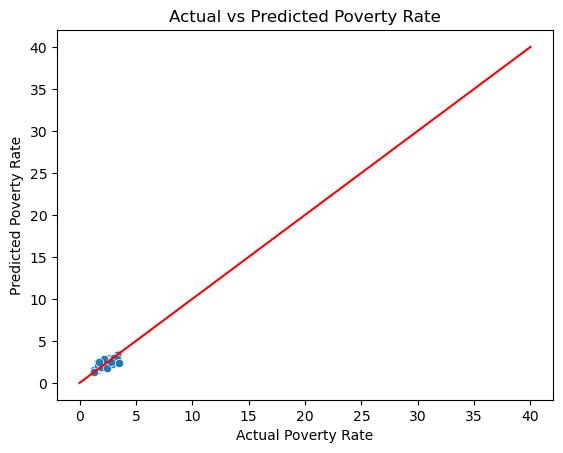

In [189]:
import matplotlib.pyplot as plt
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Poverty Rate")
plt.ylabel("Predicted Poverty Rate")
plt.title("Actual vs Predicted Poverty Rate")
plt.plot([0, 40], [0, 40], color='red', linestyle='-') 
plt.show()

In [216]:
results_df = pd.DataFrame({
    'Actual_Poverty': actual_y_test,  # True poverty rates
    'Predicted_Poverty': actual_y_pred,  # Your predictions
    'Difference': actual_y_test - actual_y_pred
})

test_indices = X_test.index  # Get the original row indices
results_df['Original_Index'] = test_indices

original_test_data = df_melted.loc[test_indices]
results_df = pd.concat([original_test_data, results_df], axis=1)

print(results_df[['Provinsi', 'Tahun', 'Actual_Poverty', 'Predicted_Poverty', 'Difference']])
results_df.to_csv('result1.csv')

                      Provinsi Tahun  Actual_Poverty  Predicted_Poverty  \
294                       Riau  2018            7.21           7.258740   
266                      Papua  2012           31.11          29.542514   
270                      Papua  2016           28.40          27.433261   
148         Kalimantan Selatan  2015            4.72           7.387826   
56                 DKI Jakarta  2011            3.75           5.021195   
..                         ...   ...             ...                ...   
274                      Papua  2020           26.64          17.309199   
189  Kepulauan Bangka Belitung  2012            5.53          10.354708   
340          Sulawesi Tenggara  2020           11.00           5.601524   
111                Jawa Tengah  2011           15.76          12.842607   
276                Papua Barat  2011           31.92           8.760082   

     Difference  
294   -0.048740  
266    1.567486  
270    0.966739  
148   -2.667826  
56    -1.

In [217]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print("LR R²:", lr.score(X_test, y_test))

LR R²: 0.3103559669919643
